<a href="https://colab.research.google.com/github/linhhvo/emotion-classifier/blob/main/Transfer-learning_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import sys
import os
import random

In [ ]:
!pip install ipython-autotime

%load_ext autotime

time: 139 µs (started: 2021-04-22 16:23:11 +00:00)


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!unzip drive/MyDrive/images.zip > /dev/null

In [ ]:
labels = os.listdir('train')
labels

['fear', 'sad', 'neutral', 'surprise', 'angry', 'happy', 'disgust']

In [ ]:
np.random.seed(212)
tf.random.set_seed(101)

time: 22.8 ms (started: 2021-04-22 16:23:25 +00:00)


In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input) \
    .flow_from_directory(directory='train', target_size=(224,224), classes=labels, batch_size=80)
validate_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input) \
    .flow_from_directory(directory='validation', target_size=(224,224), classes=labels, batch_size=80, shuffle=False)

Found 20725 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
time: 1.38 s (started: 2021-04-22 16:23:26 +00:00)


In [ ]:
# downloading the EfficientNet model excluding the top layers and increase dropout rate
efficientnet = EfficientNetB0(include_top=False, pooling='max', drop_connect_rate=0.3)

for layer in efficientnet.layers[:-25]:
    layer.trainable = False

# Freeze all base model pretrained weights
# efficientnet.trainable = False

# 
# for layer in efficientnet.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

efficientnet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, None, None, 3 0           input_8[0][0]                    
__________________________________________________________________________________________________
normalization_7 (Normalization) (None, None, None, 3 7           rescaling_7[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_7[0][0]            
_____________________________________________________________________________________

In [ ]:
# Add top layers
x = efficientnet.output
# x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

output = Dense(7, activation='softmax')(x)

model = Model(inputs=efficientnet.input, outputs=output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, None, None, 3 0           input_8[0][0]                    
__________________________________________________________________________________________________
normalization_7 (Normalization) (None, None, None, 3 7           rescaling_7[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_7[0][0]            
____________________________________________________________________________________________

In [ ]:
lr_schedule = ExponentialDecay(0.001, decay_steps=100000, decay_rate=0.95, staircase=True)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

time: 14.4 ms (started: 2021-04-22 16:23:30 +00:00)


In [ ]:
earlystopper = EarlyStopping(
    patience=20,
    restore_best_weights=True,
    verbose=1)

history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=validate_batches,
            validation_steps=len(validate_batches),
            epochs=30,
            # verbose=2,
            callbacks=[earlystopper]
)

Epoch 1/30
260/260 [==============================] - 95s 339ms/step - loss: 1.3980 - accuracy: 0.4608 - val_loss: 1.3780 - val_accuracy: 0.5220
Epoch 2/30
260/260 [==============================] - 86s 331ms/step - loss: 1.0161 - accuracy: 0.6252 - val_loss: 1.3567 - val_accuracy: 0.5315
Epoch 3/30
260/260 [==============================] - 86s 332ms/step - loss: 0.8768 - accuracy: 0.6702 - val_loss: 1.2496 - val_accuracy: 0.5660
Epoch 4/30
260/260 [==============================] - 86s 332ms/step - loss: 0.7661 - accuracy: 0.7176 - val_loss: 1.3968 - val_accuracy: 0.5590
Epoch 5/30
260/260 [==============================] - 86s 332ms/step - loss: 0.6851 - accuracy: 0.7504 - val_loss: 1.3092 - val_accuracy: 0.5745
Epoch 6/30
260/260 [==============================] - 87s 333ms/step - loss: 0.5812 - accuracy: 0.7925 - val_loss: 1.3980 - val_accuracy: 0.5700
Epoch 7/30
260/260 [==============================] - 87s 333ms/step - loss: 0.5027 - accuracy: 0.8257 - val_loss: 1.5177 - val_ac

In [ ]:
train_loss, train_acc = model.evaluate(train_batches, verbose=0)
print('Train Accuracy: {:.2f}'.format(train_acc))

print()

valid_loss, valid_acc = model.evaluate(validate_batches, verbose=0)
print('Validation Accuracy: {:.2f}'.format(valid_acc))

Train Accuracy: 0.75

Validation Accuracy: 0.57
time: 1min 17s (started: 2021-04-22 16:56:50 +00:00)


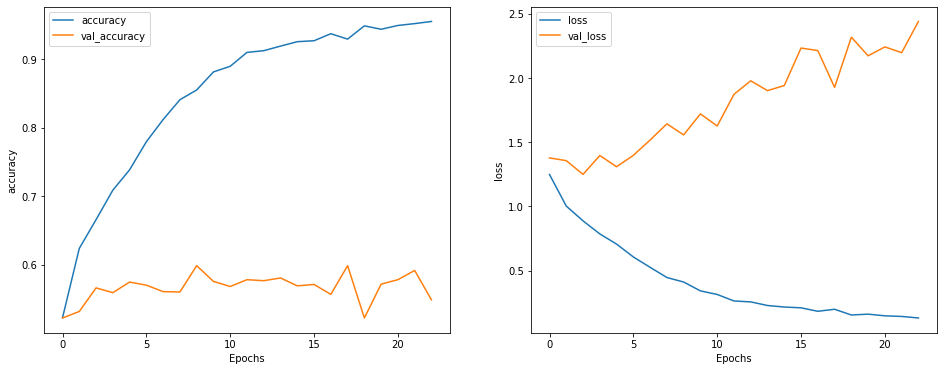

time: 471 ms (started: 2021-04-22 16:58:08 +00:00)


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '') # for validation results
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')